# Classificação do MNIST - Exercicio Modulo 3

In [1]:
#Bibliotecas Utilizadas

import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [2]:
# Configuração do dispositivo (treine nosso modelo na GPU, se disponível, pois é muito mais rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Copiado do Auxilio

# Essas transformações serão aplicadas a cada ponto de dados. Neste exemplo, queremos transformar cada
# ponto de dados em um tipo de dado tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# Vamos dividir o conjunto de dados de treinamento em treinamento e validação
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)


In [4]:
# Criação dos DataLoaders
batch_size = 500
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


In [5]:
# Arquitetura e Hiperparametros

# Dica! No notebook "Introdução ao PyTorch", do módulo 3, a rede
# que criamos requer que os dados de entrada tenham a forma Nx1, em que N é o número
# de atributos. Atualmente, nosso conjunto de dados MNIST está na forma 28x28, pois são imagens. Use
# este trecho de código enquanto itera pelos pontos de dados em seu conjunto de dados para nivelá-los,
# para que tenham o tamanho 784x1 e possam ser usados com os modelos que projetamos anteriormente!

input_size = 784 # 28X28 = 784
hidden_size1 = 100
hidden_size2 = 100
hidden_size3 = 100
num_classes = 10

# Parâmetros externos de treinamento
learning_rate = 0.001
num_epochs = 10

In [6]:
# Modelo simples de classificação com três camadas ocultas
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(SimpleClassifier, self).__init__()
        self.pipeline = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.pipeline(x)

In [7]:
model = SimpleClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(model)

SimpleClassifier(
  (pipeline): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [8]:
# De https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Manter os melhores pesos armazenados separadamente
    best_acc = 0.0
    best_epoch = 0

    # Cada época tem uma fase de treinamento, validação e teste
    phases = ['train', 'val', 'test']

    # Acompanhe como a perda e a precisão evoluem durante o treinamento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Definir o modelo no modo de treinamento
            else:
                model.eval()   # Definir o modelo no modo de avaliação

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre os dados
            for inputs, labels in dataloaders[phase]:
                # Importante! Precisamos nivelar cada ponto de dados para ser
                # compatível com nosso modelo
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zerar os gradientes dos parâmetros
                optimizer.zero_grad()

                # Propagação (forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Retropropagação (backward) e atualização dos pesos apenas na fase de treinamento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Realizar uma cópia profunda do modelo se for a melhor precisão (com base na validação)
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Carregar os melhores pesos do modelo
    model.load_state_dict(best_model_wts)

    return model, training_curves



In [9]:
# Perda e otimizador
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss para classificação
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Treinar o modelo. Também armazenaremos os resultados do treinamento para visualização.
model, training_curves = train_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.8561 Acc: 0.7459
val   Loss: 0.3489 Acc: 0.9000
test  Loss: 0.3479 Acc: 0.8988

Epoch 2/10
----------
train Loss: 0.3354 Acc: 0.9001
val   Loss: 0.2753 Acc: 0.9171
test  Loss: 0.2774 Acc: 0.9202

Epoch 3/10
----------
train Loss: 0.2782 Acc: 0.9171
val   Loss: 0.2390 Acc: 0.9279
test  Loss: 0.2433 Acc: 0.9276

Epoch 4/10
----------
train Loss: 0.2421 Acc: 0.9272
val   Loss: 0.2163 Acc: 0.9349
test  Loss: 0.2207 Acc: 0.9322

Epoch 5/10
----------
train Loss: 0.2146 Acc: 0.9360
val   Loss: 0.2003 Acc: 0.9398
test  Loss: 0.2043 Acc: 0.9365

Epoch 6/10
----------
train Loss: 0.1922 Acc: 0.9425
val   Loss: 0.1780 Acc: 0.9468
test  Loss: 0.1805 Acc: 0.9445

Epoch 7/10
----------
train Loss: 0.1743 Acc: 0.9481
val   Loss: 0.1588 Acc: 0.9528
test  Loss: 0.1600 Acc: 0.9504

Epoch 8/10
----------
train Loss: 0.1593 Acc: 0.9528
val   Loss: 0.1496 Acc: 0.9555
test  Loss: 0.1500 Acc: 0.9539

Epoch 9/10
----------
train Loss: 0.1455 Acc: 0.9568
val   Loss: 0.1436

In [10]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[phase+'_'+metric])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Definir o modelo no modo de avaliação
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Importante! Precisamos nivelar cada ponto de dados para ser
        # compatível com nosso modelo
        inputs = inputs.view(inputs.shape[0],-1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


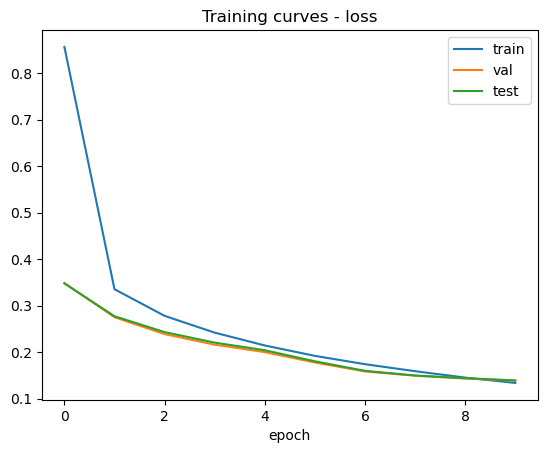

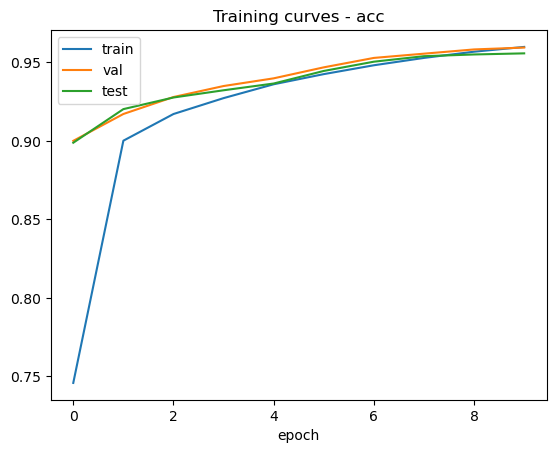

In [11]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

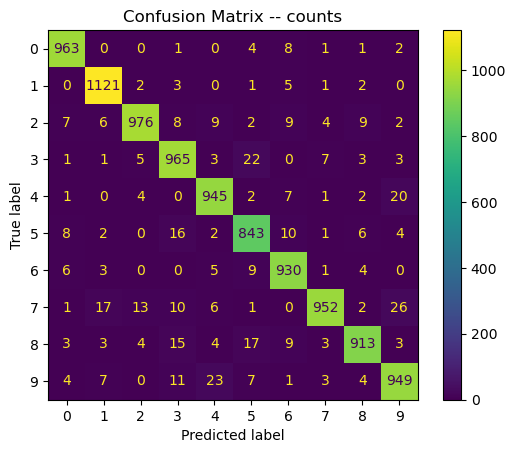

In [12]:
res = plot_cm(model, device, dataloaders, phase='test')